# Establishing relation TB to ice thickness
## introduction
The training data was generated in Huntemann et al. 2014. it consist of modeled ice thickness increase from a cumulative freezeing degree day model for the freezeup in 2010 in a Kara and Barents Seas. 
In this document we are using the sama data from SMOS and the cumulative freezing degree day model to fit an analytic equation to the dependency of brightness temperature and ice thickness. In contrast to Huntemann et al. 2014, here instead of the Intensity and Polarization difference, the horizontal and vertical polarized brightness temperatures are used directly.

## The dataset
The dataset was aquired in 2010 in the Kara and Barents Seas. From initial 10 small subregions, it was distilled to to 3 different regions (numbered 3,6, and 7 in the original dataset) due to their stability.




In [187]:
using Pkg
Pkg.activate("../sit_atbd_env_jl")
using Plots
using CSV
using LaTeXStrings
using Printf
using DataFrames
using Distributions
using LsqFit
using Markdown
using Printf

  Activating project at `~/SeaIceThickness_ATBD/sit_atbd_env_jl`


In [97]:
airt=CSV.read("../data/sit_ncep.txt",DataFrame)
region3=CSV.read("../data/region3_53.txt",DataFrame)
region6=CSV.read("../data/region6_53.txt",DataFrame)
region7=CSV.read("../data/region7_53.txt",DataFrame);

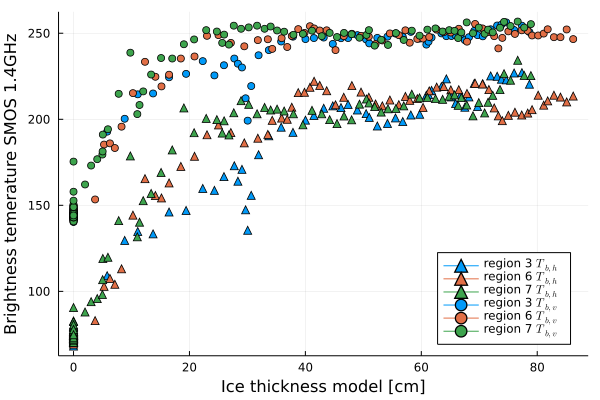

In [222]:
plot(airt.region3[1:87],region3.TBh,m=:utriangle,lw=0,c=1,label=L"region 3 $T_{b,h}")
plot!(airt.region6[1:87],region6.TBh,m=:utriangle,lw=0,c=2,label=L"region 6 $T_{b,h}")
plot!(airt.region7[1:87],region7.TBh,m=:utriangle,lw=0,c=3,label=L"region 7 $T_{b,h}")

plot!(airt.region3[1:87],region3.TBv,m=:circ,lw=0,c=1,label=L"region 3 $T_{b,v}")
plot!(airt.region6[1:87],region6.TBv,m=:circ,lw=0,c=2,label=L"region 6 $T_{b,v}")
plot!(airt.region7[1:87],region7.TBv,m=:circ,lw=0,c=3,label=L"region 7 $T_{b,v}")
plot!(legend=:bottomright)
xlabel!("Ice thickness model [cm]")
ylabel!("Brightness temerature SMOS 1.4GHz")

In [223]:
alltbh=collect(skipmissing([region3.TBh;region6.TBh;region7.TBh]))
nanidx=isnan.(alltbh)
alltbh=alltbh[.!nanidx]
alltbv=collect(skipmissing([region3.TBv;region6.TBv;region7.TBv]))
alltbv=alltbv[.!nanidx]
allsit=vcat([airt[!,i][1:87] for i=["region3","region6","region7"]]...);
allsit=allsit[.!nanidx]; #to m


## fitting 
As a fit function a simple exponential is used with 

\begin{equation}
f_p(x)= p_2 - (p_2 - p_1)\exp(-x/p_3) \label{eq:intensity} \tag{1}
\end{equation}

where $p_1$ is effectively the brightness temperature of open water close to sea ice under freezing areas under freezing conditions, $p_2$ is the brightness temerature of thick sea ice, and $p_3$ is a curvature parameter connecting the two TBs. The index $p$ of $f_p$ indicates the polarization, either $h$ or $v$.

The parameters $p_i$ are optained in a fit to the data from the three regions mentioned. 
A least square fit of equation \eqref{eq:intensity} for $T_{b,h}$ and $T_{b,v}$ individually gives 6 parameters in total.

In [229]:
@. ff(x,p)=p[2]-(p[2]-p[1])*exp(-x/p[3])
ph=curve_fit(ff,allsit,alltbh,[70.0,200.0,0.12]).param
pv=curve_fit(ff,allsit,alltbv,[70.0,200.0,0.12]).param
t(n)=@sprintf "%.3f" n

md"""
| polarization\parameter | $p_1$ | $p_2$ | $p_3$ |
| --- | --- | --- | --- |
| horizontal | $(t(ph[1])) | $(t(ph[2])) | $(t(ph[3])) |
| vertical | $(t(pv[1])) | $(t(pv[2])) | $(t(pv[3])) |
"""

| polarization\parameter |   $p_1$ |   $p_2$ |  $p_3$ |
| ----------------------:| -------:| -------:| ------:|
|             horizontal |  74.206 | 216.141 | 17.173 |
|               vertical | 145.337 | 249.830 | 10.440 |


A resulting fit through all datapoints show that the function is suitable for representation of ice thickness to brightness temperature relation

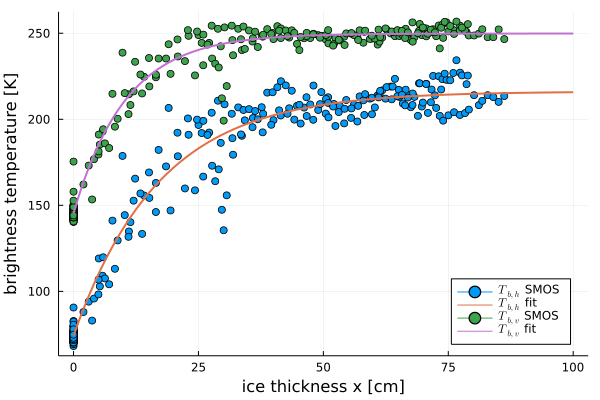

In [225]:
plot(allsit,alltbh,lw=0,markershape=:circle,label=L"$T_{b,h}$ SMOS")
xx=0:0.1:100.0
plot!(xx,ff(xx,ph),lw=2,label=L"$T_{b,h}$ fit")

plot!(allsit,alltbv,lw=0,markershape=:circle,label=L"$T_{b,v}$ SMOS")
plot!(xx,ff(xx,pv),legend=:bottomright,lw=2,label=L"$T_{b,v}$ fit")

xlabel!("ice thickness x [cm]")
ylabel!("brightness temperature [K]")

showing the relation fo polarization difference $T_{b,v} - T_{b,h}$ to ice thickness shows also good agreement with the data

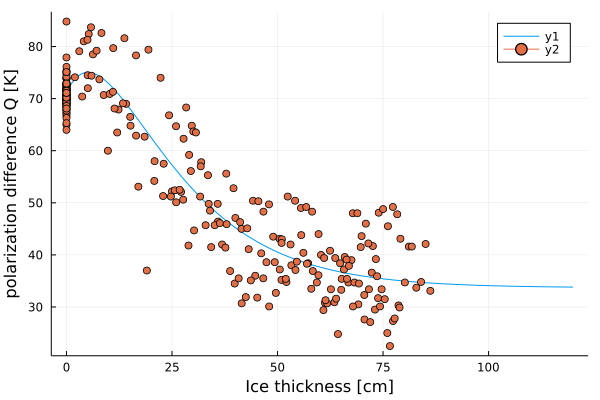

In [226]:
xx=0:0.01:120
plot(xx,ff(xx,pv).-ff(xx,ph))
plot!(allsit,alltbv.-alltbh, m=:circ,lw=0)
ylabel!("polarization difference Q [K]")
xlabel!("Ice thickness [cm]")

The polarization difference plotted versus intensity, which is the original representation used by Huntemann et al. 2014 and Paţilea et al. 2019 also shows that the fit is appropriate in the $I-Q$-space

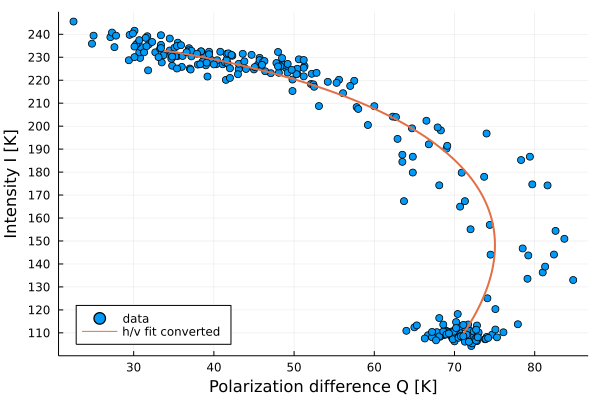

In [227]:
scatter(alltbv.-alltbh,alltbv./2 +alltbh./2,label="data")
plot!(ff(xx,pv).-ff(xx,ph),ff(xx,pv)./2 .+ff(xx,ph)./2,lw=2,label="h/v fit converted")
xlabel!("Polarization difference Q [K]")
ylabel!("Intensity I [K]")
xticks!(20:10:80)
yticks!(100:10:250,legend=:bottomleft)

In [228]:
import YAML
YAML.write_file("fit_params.yml", Dict("ph"=>ph,"pv"=>pv))